In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.features.cleaning import clean_data, split_X_and_y_data
from src.utils import get_project_root

In [54]:
dir_root = get_project_root()
dir_data = 'data'
filename_data_brain = os.path.join(
    dir_root,
    dir_data, 
    'survival_brain_2000_to_2020_seer_2022_db.csv'
)
data_raw = pd.read_csv(filename_data_brain)

/var/folders/x7/y98cqsdn699czxl0ksdv4x100000gn/T/ipykernel_14661/801828396.py:8: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(filename_data_brain)


In [55]:
data = clean_data(data_raw)

For an initial look, let's just define a list of some of the  columns that look interesting.

## Train-Test Split

In [5]:
from sklearn.model_selection import train_test_split
from sksurv.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest
from scipy import stats

In [56]:
data_train, data_test = train_test_split(
    data, 
    test_size=0.2, 
    random_state=2984, 
    shuffle=True, 
    stratify=data['Vital status recode (study cutoff used)']
)

X_train, y_train = split_X_and_y_data(data_train)
X_test , y_test  = split_X_and_y_data(data_test)

## Kaplan-Meier Curve

In [7]:
from lifelines import KaplanMeierFitter

In [8]:
kmf = KaplanMeierFitter()
kmf.fit(y_train['Survival months'], event_observed=y_train['Event indicator'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 61061 total observations, 14855 right-censored observations>

Text(0.5, 0, 'Months from diagnosis')

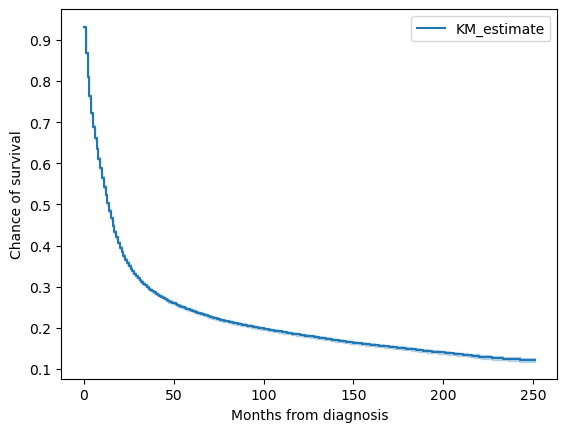

In [9]:
ax = kmf.plot_survival_function()
ax.set_ylabel('Chance of survival')
ax.set_xlabel('Months from diagnosis')

In [10]:
from lifelines.utils import median_survival_times

In [11]:
kmf.median_survival_time_

14.0

In [12]:
kmf.confidence_interval_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,0.930210,0.934197
1.0,0.865059,0.870444
2.0,0.807318,0.813559
3.0,0.759197,0.765984
4.0,0.717874,0.725034
...,...,...
247.0,0.116790,0.127347
248.0,0.116790,0.127347
249.0,0.116790,0.127347
250.0,0.116790,0.127347


In [13]:
median_survival_times(kmf.confidence_interval_)

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.5,13.0,14.0


### Trying with multiple groups

In [14]:
def plot_km_curve(X, y, stratify_class=None) -> plt.Axes:
    '''
    Plots the Kaplan-Meier curve for the data, optionally splitting the data 
    into separate classes based on one of the columns.
    '''
    ax = plt.subplot(111)
    kmf = KaplanMeierFitter()
    if stratify_class is None:
        kmf.fit(
            y_train['Survival months'], 
            event_observed=y_train['Event indicator']
        )
        kmf.plot_survival_function(ax=ax)
        ax.set_title('K-M curve')
    else:
        for name, grouped_df in X_train.join(y_train).groupby(stratify_class):
            kmf.fit(
                grouped_df["Survival months"], 
                grouped_df["Event indicator"], 
                label=name
            )
            kmf.plot_survival_function(ax=ax)
            ax.set_title(f'K-M curve for values of "{stratify_class}"')
    ax.set_ylabel('Chance of survival')
    ax.set_xlabel('Months from diagnosis')
    return ax

/var/folders/x7/y98cqsdn699czxl0ksdv4x100000gn/T/ipykernel_14661/178472140.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, grouped_df in X_train.join(y_train).groupby(stratify_class):


<Axes: title={'center': 'K-M curve for values of "Sex"'}, xlabel='Months from diagnosis', ylabel='Chance of survival'>

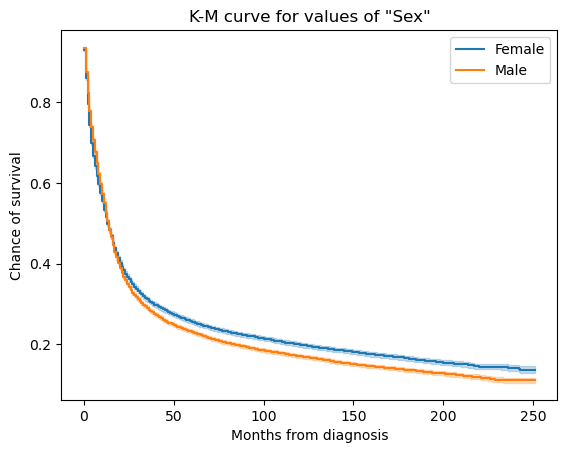

In [15]:
plot_km_curve(X_train, y_train, stratify_class='Sex')

/var/folders/x7/y98cqsdn699czxl0ksdv4x100000gn/T/ipykernel_14661/178472140.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, grouped_df in X_train.join(y_train).groupby(stratify_class):


<Axes: title={'center': 'K-M curve for values of "Race recode (W, B, AI, API)"'}, xlabel='Months from diagnosis', ylabel='Chance of survival'>

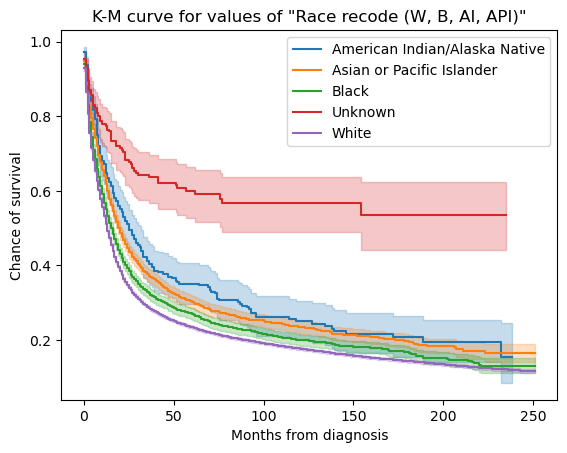

In [16]:
plot_km_curve(X_train, y_train, stratify_class='Race recode (W, B, AI, API)')

## Cox Proportional Hazards Model

In [17]:
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from src.transformers.transformers import DataFrameTransformer, DropCollinearFeatures

**Note:** To prevent `ConvergenceWarning` errors during the training below, we added the `DropCollinearFeatures` step to the preprocessing pipeline, which automatically drops the features (after the other preprocessing, such as one-hot encoding) that are highly colinear. We also adjusted the `OneHotEncoder` to `min_frequency=50` in order to drop infrequent features that were causing related issues during training with cross-validation.

For reference, the problematic features were "Histologic Type ICD-O-3", "Diagnostic Confirmation", "Histology recode - broad groupings", "SEER Combined Summary Stage 2000 (2004-2017)", and "Brain Molecular Markers (2018+)".

See for more info: https://lifelines.readthedocs.io/en/stable/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model

In [18]:
def kfold_cv_train_grid(
    data, 
    grid_penalizer, 
    grid_l1_ratio, 
    k, 
    scoring_method='log_likelihood', 
    seed=8971, 
    verbose=False,
    fitter_kwargs=None
):
    '''
    Performs a K-fold cross-validation of the data using a CoxPHFitter over the 
    specified grid of penalizer and l1_ratio points.
    '''
    mg = np.meshgrid(grid_penalizer, grid_l1_ratio)
    grid_points = np.vstack((mg[0].flatten(), mg[1].flatten())).T
    print(f'Training {k=} folds over {len(grid_points)} grid points.')

    fitters = []
    for penalizer,l1_ratio in grid_points:
        if verbose:
            print(f'(penalizer, l1_ratio) = ({penalizer}, {l1_ratio})')
        fitters.append(CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio))
        
    scores = k_fold_cross_validation(
        fitters, 
        data, 
        duration_col='Survival months', 
        event_col='Event indicator', 
        k=k, 
        scoring_method=scoring_method, 
        seed=seed, 
        fitter_kwargs=fitter_kwargs
    )
    scores = np.array(scores)
    results = pd.DataFrame.from_dict({
        'penalizer': grid_points[:,0],
        'l1_ratio': grid_points[:,1],
        'score0': scores[:,0],
        'score1': scores[:,1],
        'score2': scores[:,2],
        'score_mean': scores.mean(axis=1)
    })
    return results

def get_best_model_from_kfold_results(results: pd.DataFrame, print_results: bool=True) -> pd.Series:
    '''
    Returns the best model from the kfold_cv_train_grid results.
    '''
    model_best = results.iloc[results['score_mean'].idxmax()]
    if print_results:
        print('\nBest model:')
        print(f'  penalizer:  {model_best['penalizer']}')
        print(f'  l1_ratio:   {model_best['l1_ratio']}')
        print(f'  score_mean: {model_best['score_mean']}')
    return model_best

In [19]:
# Feature preprocessing
impute_ohe_scale = make_pipeline(
    SimpleImputer(strategy="constant", add_indicator=True).set_output(
        transform="pandas"
    ),
    DataFrameTransformer(),
    OneHotEncoder(handle_unknown="ignore", min_frequency=50, sparse_output=False),
    StandardScaler(),
)
impute_mean_scale = make_pipeline(
    SimpleImputer(strategy="mean", add_indicator=True), StandardScaler()
)

column_transformer = make_column_transformer(
    (
        StandardScaler(),
        [
            "Year of diagnosis",
            "Median household income inflation adj to 2021 (thousands USD)",
            # should we restrict the cohort to N=1?
            "Total number of in situ/malignant tumors for patient",
            "Combined Tumor Size",
            # "No tumor found",    # was causing issues training below
            "Unknown tumor size",
        ],
    ),
    (
        impute_ohe_scale,
        [
            "Age standard for survival",  # handle standardized age groupings categorically
            "Sex",
            "Race recode (W, B, AI, API)",
            "Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",
            "Marital status at diagnosis",
            "SEER Brain and CNS Recode",
            "Primary Site - labeled",
            "Histologic Type ICD-O-3", 
            "Grade Recode (thru 2017)",
            "Diagnostic Confirmation", 
            "Histology recode - broad groupings", 
            'SEER Combined Summary Stage 2000 (2004-2017)',
            "Chromosome 19q: Loss of Heterozygosity (LOH) Recode (2010+)",
            "Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)",
            "Brain Molecular Markers (2018+)", 
        ],
    ),
    (
        impute_mean_scale,
        [
            "Months from diagnosis to treatment",
        ],
    ),
    remainder="drop",
    n_jobs=-1,
)
column_transformer.set_output(transform='pandas')
pipeline = make_pipeline(
    column_transformer, 
    DropCollinearFeatures(threshold=0.95, verbose=True),
)

X_train_trans = pipeline.fit_transform(X_train, y=y_train)
dd_trans = X_train_trans.join(y_train)

Columns dropped due to colinearity:
  pipeline-1__Sex_Male
  pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic American Indian/Alaska Native
  pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic Asian or Pacific Islander
  pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic Black
  pipeline-1__Histologic Type ICD-O-3_9380
  pipeline-1__Histologic Type ICD-O-3_9382
  pipeline-1__Histologic Type ICD-O-3_9385
  pipeline-1__Histologic Type ICD-O-3_9440
  pipeline-1__Histologic Type ICD-O-3_9505
  pipeline-1__Histology recode - broad groupings_8000-8009: unspecified neoplasms
  pipeline-1__Histology recode - broad groupings_9380-9489: gliomas
  pipeline-1__Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)_Not applicable: Information not collected for this case
  pipeline-1__Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)_Not documented; Cannot be determined; Not assessed or 

In [20]:
print(f'Number of features after preprocessing: {len(dd_trans.columns)}')

Number of features after preprocessing: 116


### Testing training

Below we train on a very small hyperparameter grid with only a subset of the data. The training of the full dataset takes quite a while, but the run below is useful for testing purposes.

**Technical notes:**
- Lowering the `step_size` in the `fit_options` is necessary to avoid numerical issues. If more features are added in the future, it's possible that the `step_size` will need to be adjusted.

In [21]:
results = kfold_cv_train_grid(
    dd_trans.sample(20000, random_state=2864),
    grid_penalizer=np.logspace(-4, 2, 2),
    grid_l1_ratio=np.linspace(0.0, 1.0, 2),
    k=3,
    fitter_kwargs=dict(fit_options=dict(step_size=0.5))
)
result_best = get_best_model_from_kfold_results(results)

Training k=3 folds over 4 grid points.

Best model:
  penalizer:  0.0001
  l1_ratio:   1.0
  score_mean: 0.7773281311745683


In [164]:
def get_model_sorted_coefs(model: CoxPHFitter) -> pd.DataFrame:
    return model.summary.sort_values('coef', key=abs, ascending=False)

def plot_model_sorted_coefs(
    model: CoxPHFitter, 
    n_top_coefs: int = 20
) -> plt.Figure:
    model_sorted = get_model_sorted_coefs(model)
    fig, ax = plt.subplots(figsize=(6, n_top_coefs // 2))
    model_sorted['coef'][:n_top_coefs][::-1].plot.barh(ax=ax, legend=False)
    ax.set_xlabel("coefficient")
    ax.grid(True)
    return fig

### Training on the full dataset

#### Training with the concordance index:

In [101]:
results_full = kfold_cv_train_grid(
    dd_trans,
    grid_penalizer=np.logspace(-4, 2, 7),
    grid_l1_ratio=np.linspace(0.0, 1.0, 5),
    k=3,
    scoring_method='concordance_index',
    fitter_kwargs=dict(fit_options=dict(step_size=0.5))
)
result_full_best = get_best_model_from_kfold_results(results_full)

Training k=3 folds over 35 grid points.
(penalizer, l1_ratio) = (0.0001, 0.0)
(penalizer, l1_ratio) = (0.001, 0.0)
(penalizer, l1_ratio) = (0.01, 0.0)
(penalizer, l1_ratio) = (0.1, 0.0)
(penalizer, l1_ratio) = (1.0, 0.0)
(penalizer, l1_ratio) = (10.0, 0.0)
(penalizer, l1_ratio) = (100.0, 0.0)
(penalizer, l1_ratio) = (0.0001, 0.25)
(penalizer, l1_ratio) = (0.001, 0.25)
(penalizer, l1_ratio) = (0.01, 0.25)
(penalizer, l1_ratio) = (0.1, 0.25)
(penalizer, l1_ratio) = (1.0, 0.25)
(penalizer, l1_ratio) = (10.0, 0.25)
(penalizer, l1_ratio) = (100.0, 0.25)
(penalizer, l1_ratio) = (0.0001, 0.5)
(penalizer, l1_ratio) = (0.001, 0.5)
(penalizer, l1_ratio) = (0.01, 0.5)
(penalizer, l1_ratio) = (0.1, 0.5)
(penalizer, l1_ratio) = (1.0, 0.5)
(penalizer, l1_ratio) = (10.0, 0.5)
(penalizer, l1_ratio) = (100.0, 0.5)
(penalizer, l1_ratio) = (0.0001, 0.75)
(penalizer, l1_ratio) = (0.001, 0.75)
(penalizer, l1_ratio) = (0.01, 0.75)
(penalizer, l1_ratio) = (0.1, 0.75)
(penalizer, l1_ratio) = (1.0, 0.75)
(pena

The commented out line below can be used when rerunning the notebook if you don't want to redo the training again.

In [22]:
# cph_best = CoxPHFitter(penalizer=result_full_best.penalizer, l1_ratio=result_full_best.l1_ratio)
cph_best = CoxPHFitter(penalizer=0.001, l1_ratio=0.75)
cph_best.fit(dd_trans, duration_col='Survival months', event_col='Event indicator', show_progress=False)
cph_best.print_summary(decimals=3)

<lifelines.CoxPHFitter: fitted with 61061 total observations, 14855 right-censored observations>
             duration col = 'Survival months'
                event col = 'Event indicator'
                penalizer = 0.001
                 l1 ratio = 0.75
      baseline estimation = breslow
   number of observations = 61061
number of events observed = 46206
   partial log-likelihood = -455799.710
         time fit was run = 2024-05-30 21:04:22 UTC

---
                                                                                                                                                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                                                                                                           
standardscaler__Year of diagnosis                                                                                                                 -0.072     0.930     0.009          -0.089          -0.055               0.915               0.946
standardscaler__Median household income inflation adj to 2021 (thousands USD)                                                                     -0.057     0.944     0.005          -0.067          -0.048               0.936               0.953
standardscaler__Total number of in situ/malignant tumors for patient                                                                              -0.098     0.906     0.005          -0.108          -0.088               0.897               0.916
standardscaler__Combined Tumor Size                                                                                                                0.039     1.039     0.004           0.031           0.047               1.031               1.048
standardscaler__Unknown tumor size                                                                                                                 0.028     1.029     0.006           0.017           0.039               1.017               1.040
pipeline-1__Age standard for survival_15                                                                                                          -0.411     0.663     0.008          -0.426          -0.396               0.653               0.673
pipeline-1__Age standard for survival_45                                                                                                          -0.123     0.884     0.006          -0.134          -0.112               0.875               0.894
pipeline-1__Age standard for survival_55                                                                                                           0.000     1.000     0.000          -0.000           0.000               1.000               1.000
pipeline-1__Age standard for survival_65                                                                                                           0.136     1.145     0.005           0.125           0.146               1.133               1.158
pipeline-1__Age standard for survival_75                                                                                                           0.330     1.391     0.006           0.319           0.341               1.376               1.407
pipeline-1__Sex_Female                                                                                                                            -0.059     0.942     0.005          -0.069          -0.050               0.933               0.951
pipeline-1__Race recode (W, B, AI, API)_American Indian/Alaska Native                                                                             -0.002     0.998     0.005          -0.012           0.008               0.988               1.008
pipeline-1__Race recode (W, B, AI, API)_Asian or Pacific Islander                                                

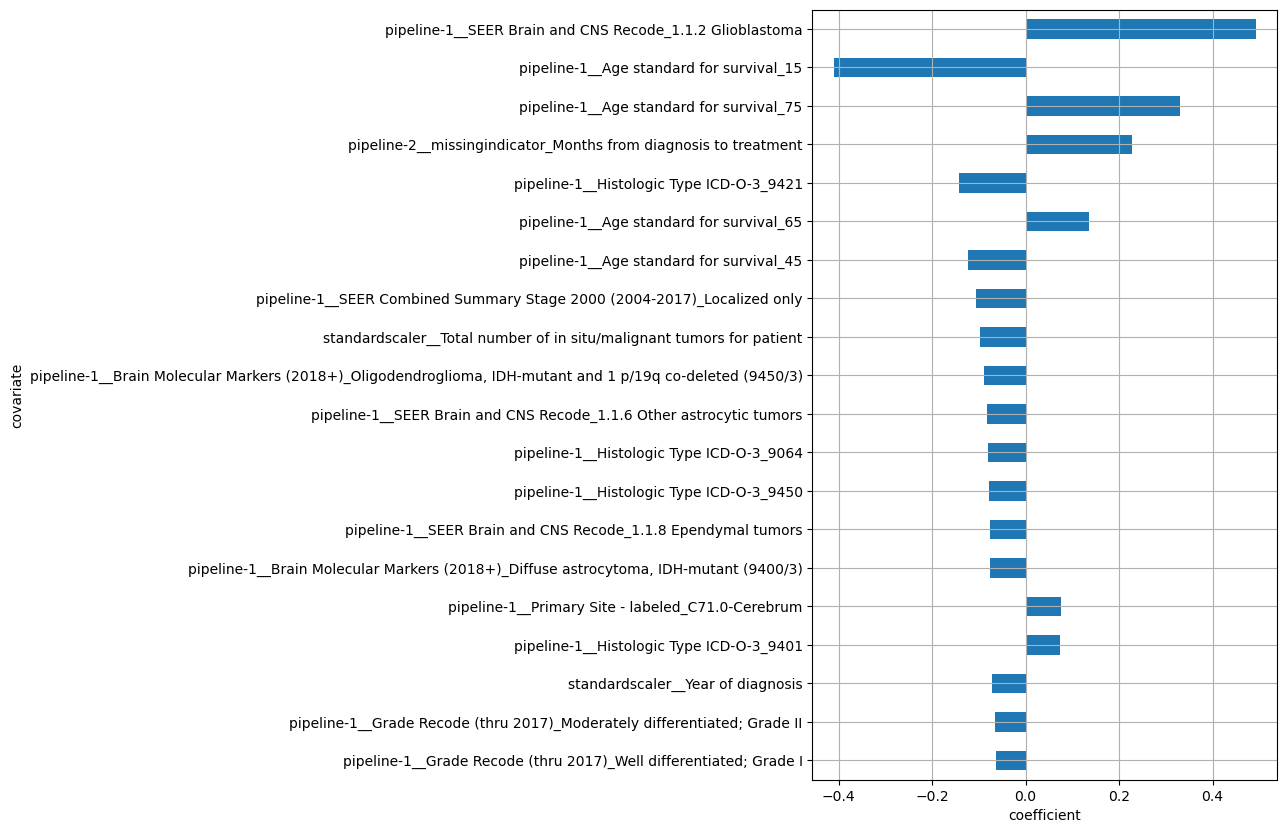

In [165]:
model_sorted = get_model_sorted_coefs(cph_best)
fig = plot_model_sorted_coefs(cph_best)

In [166]:
model_sorted.head(20)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
pipeline-1__SEER Brain and CNS Recode_1.1.2 Glioblastoma,0.493639,1.638267,0.017384,0.459567,0.527712,1.583388,1.695049,0.0,28.395681,2.286345e-177,586.788229
pipeline-1__Age standard for survival_15,-0.411094,0.662925,0.007531,-0.425855,-0.396332,0.653211,0.672783,0.0,-54.583734,0.000000e+00,inf
pipeline-1__Age standard for survival_75,0.330319,1.391411,0.005628,0.319288,0.341350,1.376147,1.406845,0.0,58.690197,0.000000e+00,inf
pipeline-2__missingindicator_Months from diagnosis to treatment,0.227607,1.255592,0.006601,0.214668,0.240545,1.239451,1.271943,0.0,34.478402,1.690566e-260,862.943798
pipeline-1__Histologic Type ICD-O-3_9421,-0.142975,0.866776,0.020879,-0.183898,-0.102052,0.832021,0.902982,0.0,-6.847669,7.506313e-12,36.955033
pipeline-1__Age standard for survival_65,0.135733,1.145377,0.005384,0.125181,0.146286,1.133353,1.157527,0.0,25.210304,3.088209e-140,463.443163
pipeline-1__Age standard for survival_45,-0.122940,0.884317,0.005566,-0.133848,-0.112032,0.874723,0.894016,0.0,-22.089414,3.995443e-108,356.769879
pipeline-1__SEER Combined Summary Stage 2000 (2004-2017)_Localized only,-0.106843,0.898667,0.008972,-0.124427,-0.089259,0.883003,0.914609,0.0,-11.908950,1.063075e-32,106.213456
standardscaler__Total number of in situ/malignant tumors for patient,-0.098178,0.906488,0.005223,-0.108415,-0.087940,0.897255,0.915816,0.0,-18.796050,8.135336e-79,259.408118


#### Training with the log-likelihood

In [39]:
results_ll_full = kfold_cv_train_grid(
    dd_trans,
    grid_penalizer=np.logspace(-4, 2, 7),
    grid_l1_ratio=np.linspace(0.0, 1.0, 5),
    k=3,
    fitter_kwargs=dict(fit_options=dict(step_size=0.5)),
    scoring_method='log_likelihood'
)
result_ll_full_best = get_best_model_from_kfold_results(results_ll_full)

Training k=3 folds over 35 grid points.

Best model:
  penalizer:  0.001
  l1_ratio:   1.0
  score_mean: -6.632085946759428


In [40]:
cph_ll_best = CoxPHFitter(penalizer=result_ll_full_best.penalizer, l1_ratio=result_ll_full_best.l1_ratio)
# cph_ll_best = CoxPHFitter(penalizer=0.001, l1_ratio=0.75)
cph_ll_best.fit(dd_trans, duration_col='Survival months', event_col='Event indicator', show_progress=False)
cph_ll_best.print_summary(decimals=3)

<lifelines.CoxPHFitter: fitted with 61061 total observations, 14855 right-censored observations>
             duration col = 'Survival months'
                event col = 'Event indicator'
                penalizer = 0.001
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 61061
number of events observed = 46206
   partial log-likelihood = -455863.144
         time fit was run = 2024-05-30 23:00:41 UTC

---
                                                                                                                                                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                                                                                                           
standardscaler__Year of diagnosis                                                                                                                 -0.072     0.931     0.009          -0.089          -0.055               0.915               0.947
standardscaler__Median household income inflation adj to 2021 (thousands USD)                                                                     -0.057     0.944     0.005          -0.066          -0.048               0.936               0.953
standardscaler__Total number of in situ/malignant tumors for patient                                                                              -0.098     0.907     0.005          -0.108          -0.088               0.898               0.916
standardscaler__Combined Tumor Size                                                                                                                0.038     1.039     0.004           0.030           0.046               1.031               1.048
standardscaler__Unknown tumor size                                                                                                                 0.028     1.028     0.006           0.017           0.038               1.017               1.039
pipeline-1__Age standard for survival_15                                                                                                          -0.411     0.663     0.008          -0.426          -0.396               0.653               0.673
pipeline-1__Age standard for survival_45                                                                                                          -0.123     0.885     0.006          -0.134          -0.112               0.875               0.894
pipeline-1__Age standard for survival_55                                                                                                           0.000     1.000     0.000          -0.000           0.000               1.000               1.000
pipeline-1__Age standard for survival_65                                                                                                           0.136     1.145     0.005           0.125           0.146               1.133               1.157
pipeline-1__Age standard for survival_75                                                                                                           0.330     1.391     0.006           0.319           0.341               1.376               1.407
pipeline-1__Sex_Female                                                                                                                            -0.059     0.943     0.005          -0.068          -0.050               0.934               0.952
pipeline-1__Race recode (W, B, AI, API)_American Indian/Alaska Native                                                                             -0.002     0.998     0.005          -0.012           0.008               0.988               1.008
pipeline-1__Race recode (W, B, AI, API)_Asian or Pacific Islander                                                 

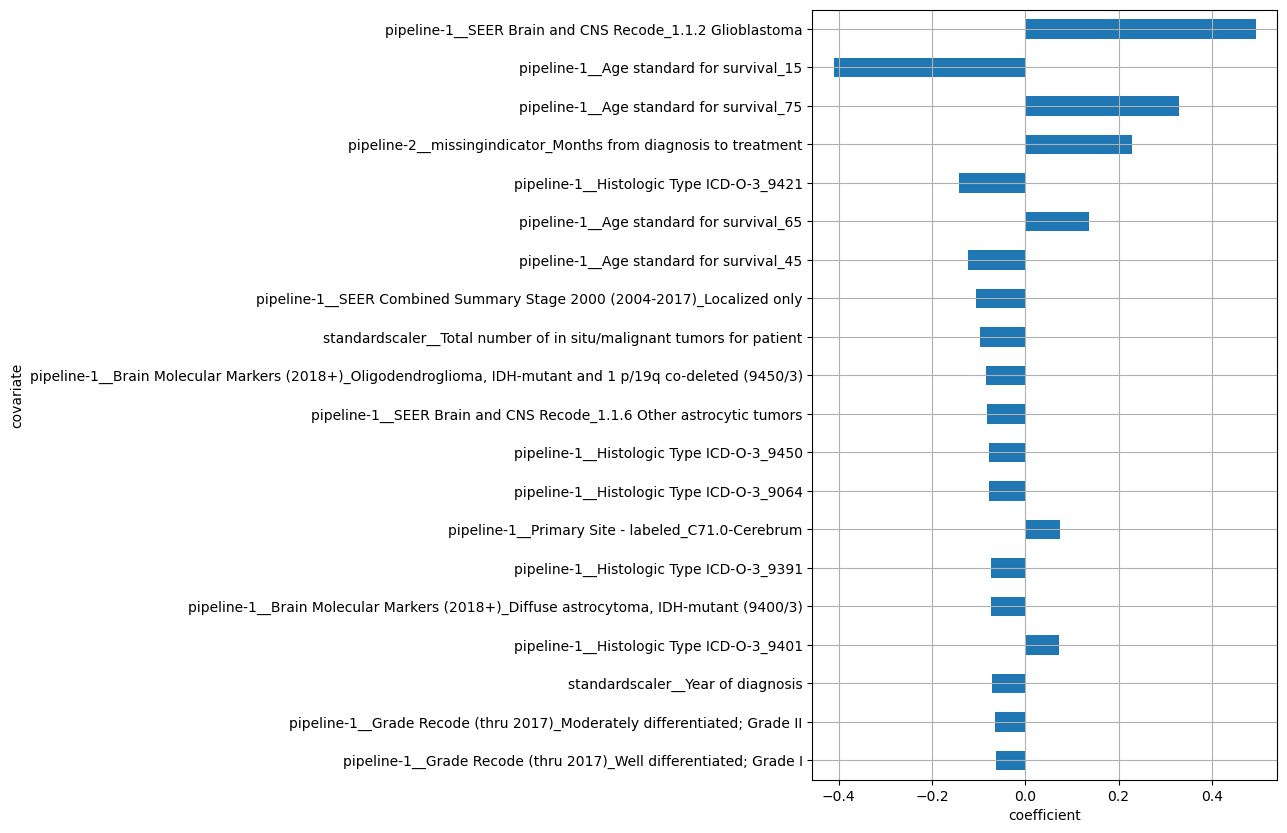

In [163]:
model_sorted = get_model_sorted_coefs(cph_ll_best)
fig = plot_model_sorted_coefs(cph_ll_best)

In [167]:
model_sorted.head(20)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
pipeline-1__SEER Brain and CNS Recode_1.1.2 Glioblastoma,0.493639,1.638267,0.017384,0.459567,0.527712,1.583388,1.695049,0.0,28.395681,2.286345e-177,586.788229
pipeline-1__Age standard for survival_15,-0.411094,0.662925,0.007531,-0.425855,-0.396332,0.653211,0.672783,0.0,-54.583734,0.000000e+00,inf
pipeline-1__Age standard for survival_75,0.330319,1.391411,0.005628,0.319288,0.341350,1.376147,1.406845,0.0,58.690197,0.000000e+00,inf
pipeline-2__missingindicator_Months from diagnosis to treatment,0.227607,1.255592,0.006601,0.214668,0.240545,1.239451,1.271943,0.0,34.478402,1.690566e-260,862.943798
pipeline-1__Histologic Type ICD-O-3_9421,-0.142975,0.866776,0.020879,-0.183898,-0.102052,0.832021,0.902982,0.0,-6.847669,7.506313e-12,36.955033
pipeline-1__Age standard for survival_65,0.135733,1.145377,0.005384,0.125181,0.146286,1.133353,1.157527,0.0,25.210304,3.088209e-140,463.443163
pipeline-1__Age standard for survival_45,-0.122940,0.884317,0.005566,-0.133848,-0.112032,0.874723,0.894016,0.0,-22.089414,3.995443e-108,356.769879
pipeline-1__SEER Combined Summary Stage 2000 (2004-2017)_Localized only,-0.106843,0.898667,0.008972,-0.124427,-0.089259,0.883003,0.914609,0.0,-11.908950,1.063075e-32,106.213456
standardscaler__Total number of in situ/malignant tumors for patient,-0.098178,0.906488,0.005223,-0.108415,-0.087940,0.897255,0.915816,0.0,-18.796050,8.135336e-79,259.408118


#### Training with the full age information instead of the "Age standard for survival"

In [57]:
# Feature preprocessing
impute_ohe_scale = make_pipeline(
    SimpleImputer(strategy="constant", add_indicator=True).set_output(
        transform="pandas"
    ),
    DataFrameTransformer(),
    OneHotEncoder(handle_unknown="ignore", min_frequency=50, sparse_output=False),
    StandardScaler(),
)
impute_mean_scale = make_pipeline(
    SimpleImputer(strategy="mean", add_indicator=True), StandardScaler()
)

column_transformer2 = make_column_transformer(
    (
        StandardScaler(),
        [
            'Age recode with <1 year olds',
            "Year of diagnosis",
            "Median household income inflation adj to 2021 (thousands USD)",
            # should we restrict the cohort to N=1?
            "Total number of in situ/malignant tumors for patient",
            "Combined Tumor Size",
            # "No tumor found",    # was causing issues training below
            "Unknown tumor size",
        ],
    ),
    (
        impute_ohe_scale,
        [
            # "Age standard for survival",  # handle standardized age groupings categorically
            "Sex",
            "Race recode (W, B, AI, API)",
            "Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",
            "Marital status at diagnosis",
            "SEER Brain and CNS Recode",
            "Primary Site - labeled",
            "Histologic Type ICD-O-3", 
            "Grade Recode (thru 2017)",
            "Diagnostic Confirmation", 
            "Histology recode - broad groupings", 
            'SEER Combined Summary Stage 2000 (2004-2017)',
            "Chromosome 19q: Loss of Heterozygosity (LOH) Recode (2010+)",
            "Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)",
            "Brain Molecular Markers (2018+)", 
        ],
    ),
    (
        impute_mean_scale,
        [
            "Months from diagnosis to treatment",
        ],
    ),
    remainder="drop",
    n_jobs=-1,
)
column_transformer2.set_output(transform='pandas')
pipeline2 = make_pipeline(
    column_transformer2, 
    DropCollinearFeatures(threshold=0.95, verbose=True),
)

X_train_trans2 = pipeline2.fit_transform(X_train, y=y_train)
dd_trans2 = X_train_trans2.join(y_train)

Columns dropped due to colinearity:
  pipeline-1__Sex_Male
  pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic American Indian/Alaska Native
  pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic Asian or Pacific Islander
  pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic Black
  pipeline-1__Histologic Type ICD-O-3_9380
  pipeline-1__Histologic Type ICD-O-3_9382
  pipeline-1__Histologic Type ICD-O-3_9385
  pipeline-1__Histologic Type ICD-O-3_9440
  pipeline-1__Histologic Type ICD-O-3_9505
  pipeline-1__Histology recode - broad groupings_8000-8009: unspecified neoplasms
  pipeline-1__Histology recode - broad groupings_9380-9489: gliomas
  pipeline-1__Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)_Not applicable: Information not collected for this case
  pipeline-1__Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)_Not documented; Cannot be determined; Not assessed or 

In [58]:
print(f'Number of features after preprocessing: {len(dd_trans2.columns)}')

Number of features after preprocessing: 112


In [59]:
results_ll_rawage_full = kfold_cv_train_grid(
    dd_trans2,
    grid_penalizer=np.logspace(-4, 2, 7),
    grid_l1_ratio=np.linspace(0.0, 1.0, 5),
    k=3,
    fitter_kwargs=dict(fit_options=dict(step_size=0.5)),
    scoring_method='log_likelihood'
)
result_ll_rawage_full_best = get_best_model_from_kfold_results(results_ll_rawage_full)

Training k=3 folds over 35 grid points.

Best model:
  penalizer:  0.001
  l1_ratio:   1.0
  score_mean: -6.625431015599109


In [67]:
cph_ll_rawage_best = CoxPHFitter(penalizer=result_ll_rawage_full_best.penalizer, l1_ratio=result_ll_rawage_full_best.l1_ratio)
# cph_ll_rawage_best = CoxPHFitter(penalizer=0.001, l1_ratio=1.0)
cph_ll_rawage_best.fit(dd_trans2, duration_col='Survival months', event_col='Event indicator', show_progress=False)
cph_ll_rawage_best.print_summary(decimals=3)

<lifelines.CoxPHFitter: fitted with 61061 total observations, 14855 right-censored observations>
             duration col = 'Survival months'
                event col = 'Event indicator'
                penalizer = 0.001
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 61061
number of events observed = 46206
   partial log-likelihood = -455436.933
         time fit was run = 2024-05-31 16:58:56 UTC

---
                                                                                                                                                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                                                                                                           
standardscaler__Age recode with <1 year olds                                                                                                       0.705     2.025     0.007           0.692           0.719               1.997               2.052
standardscaler__Year of diagnosis                                                                                                                 -0.078     0.925     0.009          -0.095          -0.061               0.910               0.941
standardscaler__Median household income inflation adj to 2021 (thousands USD)                                                                     -0.058     0.944     0.005          -0.067          -0.048               0.936               0.953
standardscaler__Total number of in situ/malignant tumors for patient                                                                              -0.100     0.905     0.005          -0.110          -0.090               0.895               0.914
standardscaler__Combined Tumor Size                                                                                                                0.037     1.038     0.004           0.029           0.046               1.030               1.047
standardscaler__Unknown tumor size                                                                                                                 0.026     1.027     0.006           0.016           0.037               1.016               1.038
pipeline-1__Sex_Female                                                                                                                            -0.059     0.943     0.005          -0.068          -0.049               0.934               0.952
pipeline-1__Race recode (W, B, AI, API)_American Indian/Alaska Native                                                                             -0.001     0.999     0.005          -0.011           0.009               0.989               1.009
pipeline-1__Race recode (W, B, AI, API)_Asian or Pacific Islander                                                                                 -0.009     0.991     0.007          -0.022           0.004               0.979               1.004
pipeline-1__Race recode (W, B, AI, API)_Black                                                                                                      0.000     1.000     0.000          -0.000           0.000               1.000               1.000
pipeline-1__Race recode (W, B, AI, API)_Unknown                                                                                                   -0.022     0.979     0.012          -0.045           0.002               0.956               1.002
pipeline-1__Race recode (W, B, AI, API)_White                                                                                                      0.019     1.020     0.007           0.006           0.033               1.006               1.034
pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Hispanic (All Races)                       

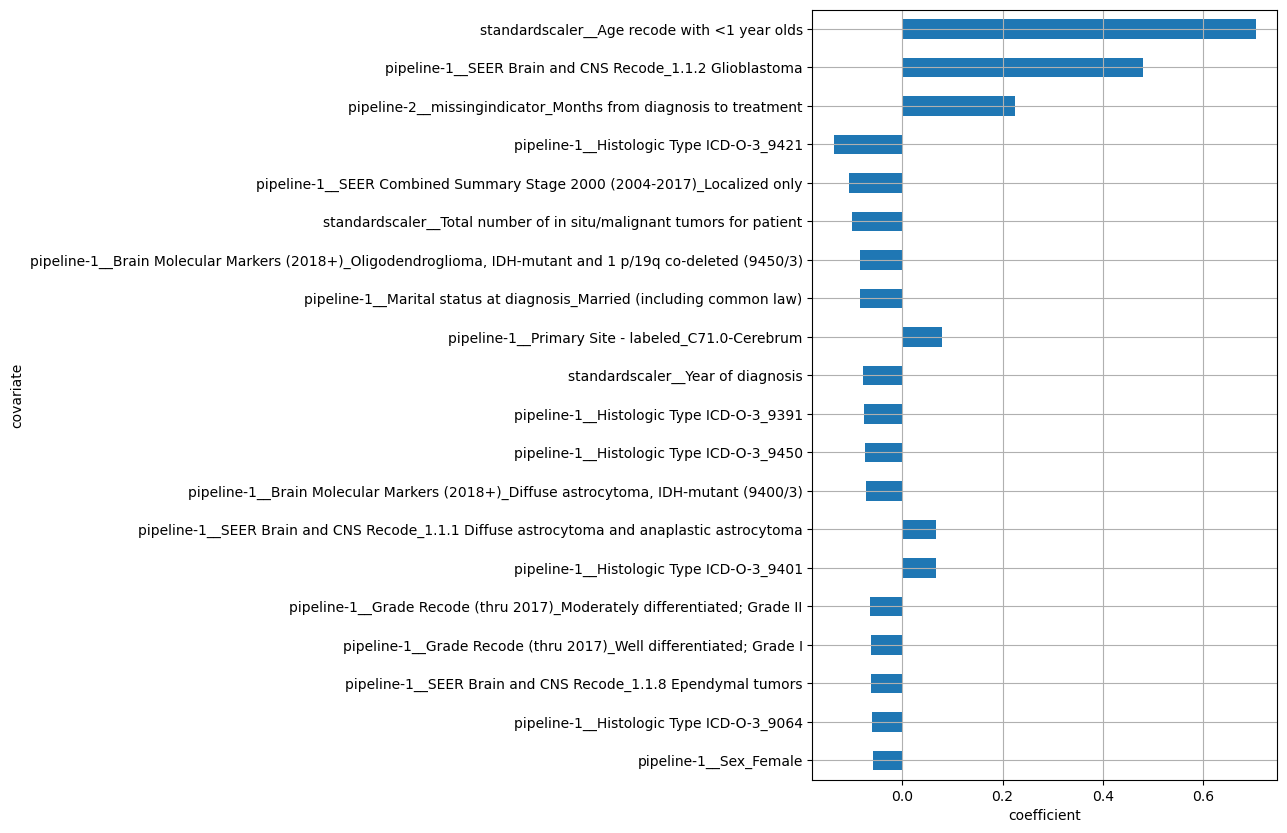

In [161]:
model_sorted = get_model_sorted_coefs(cph_ll_rawage_best)
fig = plot_model_sorted_coefs(cph_ll_rawage_best)

In [162]:
model_sorted = get_model_sorted_coefs(cph_ll_rawage_best)
model_sorted.head(20)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
standardscaler__Age recode with <1 year olds,0.705421,2.024699,0.006949,0.691800,0.719042,1.997308,2.052465,0.0,101.507499,0.000000e+00,inf
pipeline-1__SEER Brain and CNS Recode_1.1.2 Glioblastoma,0.479870,1.615865,0.017331,0.445901,0.513839,1.561897,1.671697,0.0,27.687832,9.784352e-169,558.115372
pipeline-2__missingindicator_Months from diagnosis to treatment,0.224141,1.251248,0.006589,0.211227,0.237055,1.235193,1.267511,0.0,34.017936,1.209863e-253,840.172964
pipeline-1__Histologic Type ICD-O-3_9421,-0.136541,0.872370,0.020922,-0.177547,-0.095535,0.837322,0.908886,0.0,-6.526279,6.742362e-11,33.787955
pipeline-1__SEER Combined Summary Stage 2000 (2004-2017)_Localized only,-0.106124,0.899313,0.008984,-0.123732,-0.088516,0.883617,0.915288,0.0,-11.813030,3.342940e-32,104.560581
standardscaler__Total number of in situ/malignant tumors for patient,-0.100217,0.904641,0.005228,-0.110463,-0.089970,0.895419,0.913959,0.0,-19.169446,6.661471e-82,269.662263
"pipeline-1__Brain Molecular Markers (2018+)_Oligodendroglioma, IDH-mutant and 1 p/19q co-deleted (9450/3)",-0.084251,0.919200,0.021615,-0.126617,-0.041886,0.881071,0.958979,0.0,-3.897747,9.709183e-05,13.330291
pipeline-1__Marital status at diagnosis_Married (including common law),-0.082909,0.920434,0.006779,-0.096197,-0.069622,0.908285,0.932746,0.0,-12.229696,2.157450e-34,111.836228
pipeline-1__Primary Site - labeled_C71.0-Cerebrum,0.079155,1.082373,0.005186,0.068991,0.089319,1.071427,1.093430,0.0,15.263771,1.333168e-52,172.325402


The hazard ratio gives the increase in risk associated with a unit increase in a given feature. Since the continuous features have been standardized, this represents a 1 standard deviation increase in the feature. Therefore, we have to invert the standardization to be able to interpret the hazard ratios in meaningful terms. Below we calculate the standard deviations for the continuous features:

In [148]:
ct = pipeline2.named_steps['columntransformer']
cont_feature_scales = ct.named_transformers_['standardscaler'].scale_
cont_feature_names = ct.named_transformers_['standardscaler'].feature_names_in_
df_cont_feature_scales = pd.DataFrame(cont_feature_scales, index=cont_feature_names, columns=['std'])
print('Continuous feature preprocessing scales:')
df_cont_feature_scales

Continuous feature preprocessing scales:


,std
Age recode with <1 year olds,17.717406
Year of diagnosis,5.942432
Median household income inflation adj to 2021 (thousands USD),11.473908
Total number of in situ/malignant tumors for patient,0.179347
Combined Tumor Size,37.456698
Unknown tumor size,0.426997
